# Airlines Twitter Posts Sentiment Analysis Using NLP

### Tianyao Liu
### Simon Business School

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [222]:
# read two files
pos = pd.read_csv('noncomplaint1700.csv')
neg = pd.read_csv('complaint1700.csv')

## Data Cleaning

In [223]:
print(pos.head())
print(neg.head())

     id    airline                                              tweet
0   404     United  @brianfadem @united The best summertime soap o...
1   706  SouthWest  @aresef @united yes the change fees are cheape...
2   882  SouthWest  @SouthwestAir Do you guys not fly from Birming...
3  1196     United  This mornings @united #flight seems to be on t...
4  1244    JetBlue  @JetBlue @Boston_Calling I have never been to ...
       id    airline                                              tweet
0   80938     United  @united I'm having issues. Yesterday I rebooke...
1   10959     United  @united kinda feel like the $6.99 you charge f...
2  130813  SouthWest  Livid in Vegas, delayed, again&amp; again&amp;...
3  146589     United  @united the most annoying man on earth is on m...
4  117579     United  @united The last 2 weeks I've flown wit u, you...


In [224]:
# add label column
pos['label'] = 'pos' #positive
neg['label'] = 'neg' #negative

In [225]:
posts = pd.concat([pos,neg],axis=0).reset_index()

## Exploratory Analysis

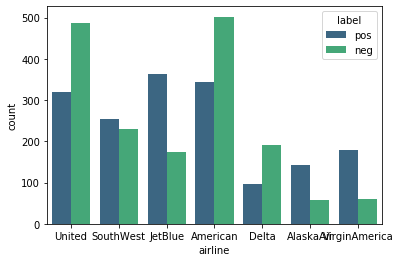

In [226]:
# positive and negative airlines
sns.countplot(x='airline',data=posts,hue='label',palette='viridis')
# JetBlue got the most positive comments; American airlines got the most negative comments

In [227]:
# create a column containing text length
posts['len'] = posts['tweet'].apply(len)

In [228]:
posts['len'].describe()

count    3400.000000
mean      112.362647
std        29.523298
min        15.000000
25%        94.000000
50%       123.000000
75%       137.000000
max       187.000000
Name: len, dtype: float64

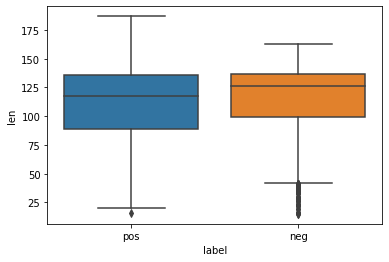

In [229]:
sns.boxplot(x='label',data=posts,y='len')
# not nuch differences! 
# Except negative posts have less variance in length but more small outliers
# That's probably because of the negative sentiment. People does not want to describe much.

## NLP

In [230]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [231]:
import string
from nltk.corpus import stopwords

In [232]:
# function to remove punctuation as stopwords
# function to remove punctuation as stopwords
def text_process(mess):
    
    # punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join to form the string.
    nopunc = ''.join(nopunc)
    
    # stopwords
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [233]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(posts['tweet'], posts['label'], test_size=0.3,random_state=101)

print(len(X_train), len(X_test), len(y_train) + len(y_test))

2380 1020 3400


### (1) Naive Bayes

In [253]:
from sklearn.pipeline import Pipeline
# pass in a list
pipelineNB = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [254]:
pipelineNB.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x1a17ac1d08>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [255]:
predictionsNB = pipeline.predict(X_test)

In [256]:
# evaluation
from sklearn.metrics import classification_report, confusion_matrix

In [257]:
print(confusion_matrix(predictionsNB,y_test))
print(classification_report(predictionsNB,y_test))

[[426 215]
 [ 72 307]]
              precision    recall  f1-score   support

         neg       0.86      0.66      0.75       641
         pos       0.59      0.81      0.68       379

    accuracy                           0.72      1020
   macro avg       0.72      0.74      0.71      1020
weighted avg       0.76      0.72      0.72      1020



### (2) Random Forest

In [239]:
from sklearn.ensemble import RandomForestClassifier

In [252]:
#just change third elements of pipeline
pipelineRF = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', RandomForestClassifier()),  # train on TF-IDF vectors w/ Random Forest
])

In [258]:
pipelineRF.fit(X_train,y_train)
predictionsRF = pipelineRF.predict(X_test)

print(confusion_matrix(predictionsRF,y_test))
print(classification_report(predictionsRF,y_test))

# not as good as Naive Bayes

/Users/liutianyao/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[389 189]
 [109 333]]
              precision    recall  f1-score   support

         neg       0.78      0.67      0.72       578
         pos       0.64      0.75      0.69       442

    accuracy                           0.71      1020
   macro avg       0.71      0.71      0.71      1020
weighted avg       0.72      0.71      0.71      1020



### (3) Logistic Regression

In [242]:
from sklearn.linear_model import LogisticRegression

In [243]:
pipelineLR = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression()),  # train on TF-IDF vectors w/ Logistic Regression
])

In [259]:
pipelineLR.fit(X_train,y_train)
predictionsLR = pipelineLR.predict(X_test)

print(confusion_matrix(predictionsLR,y_test))
print(classification_report(predictionsLR,y_test))

# also good!

/Users/liutianyao/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[387 141]
 [111 381]]
              precision    recall  f1-score   support

         neg       0.78      0.73      0.75       528
         pos       0.73      0.77      0.75       492

    accuracy                           0.75      1020
   macro avg       0.75      0.75      0.75      1020
weighted avg       0.75      0.75      0.75      1020



## Pass Naive Bayes to the unlabelled test data

In [245]:
test = pd.read_csv('temp.csv')

In [246]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4553 entries, 0 to 4552
Data columns (total 5 columns):
id                    4553 non-null int64
tid_not_to_be_used    4553 non-null float64
airline               4553 non-null object
tag                   4553 non-null object
tweet                 4553 non-null object
dtypes: float64(1), int64(1), object(3)
memory usage: 177.9+ KB


In [247]:
test.head()

,id,tid_not_to_be_used,airline,tag,tweet
0,72,5.062687e+17,SouthWest,dM}c5i95_Wot,@SouthwestAir the upside to being stuck on a p...
1,90,5.062885e+17,United,dM}c5i95_Wot,After a 5 hour weather delay in Newark I misse...
2,91,5.062894e+17,JetBlue,dM}c5i95_Wot,@ArianFoster never mess around with those old ...
3,99,5.063009e+17,United,dM}c5i95_Wot,@CTony202 @united walking would probably be pr...
4,197,5.064596e+17,VirginAmerica,dM}c5i95_Wot,@IIJERiiCHOII @VirginAmerica Shit man that sucks


In [265]:
predictionsNB = pipelineNB.predict(test['tweet'])

In [266]:
test['label'] = predictionsNB

In [267]:
test['label'].value_counts()

neg    3687
pos     866
Name: label, dtype: int64